# Giới thiệu Convolution Nets

Convolutional Neural Networks (CNN) là một trong những mô hình deep learning phổ biến nhất và có ảnh hưởng nhiều nhất trong cộng đồng Computer Vision. CNN được dùng trong trong nhiều bài toán như nhận dạng ảnh, phân tích video, ảnh MRI, hoặc cho bài các bài của lĩnh vực xử lý ngôn ngữ tự nhiên, và hầu hết đều giải quyết tốt các bài toán này. 

CNN cũng có lịch sử khá lâu đời. Kiến trúc gốc của mô hình CNN được giới thiệu bởi một nhà khoa học máy tính người Nhật vào năm 1980. Sau đó, năm 1998, Yan LeCun lần đầu huấn luyện mô hình CNN với thuật toán backpropagation cho bài toán nhận dạng chữ viết tay. Tuy nhiên, mãi đến năm 2012, khi một nhà khoa học máy tính người Ukraine Alex Krizhevsky (đệ của Geoffrey Hinton) xây dựng mô hình CNN (AlexNet) và sử dụng GPU để tăng tốc quá trình huấn luyện deep nets để đạt được top 1 trong cuộc thi Computer Vision thường niên ImageNet với độ lỗi phân lớp top 5 giảm hơn 10% so với những mô hình truyền thống trước đó, đã tạo nên làn sóng mãnh mẽ sử dụng deep CNN với sự hỗ trợ của GPU để giải quyết càng nhiều các vấn đề trong Computer Vision.

# Bài Toán Phân loại Ảnh
Phân loại ảnh là một bài toán quan trọng bậc nhất trong lĩnh vực Computer Vision. Chúng ta đã có rất nhiều nghiên cứu để giải quyết bài toán này bằng cách rút trích các đặc trưng rất phổ biến như SIFT, HOG rồi cho máy tính học nhưng những cách này tỏ ra không thực sự hiểu quả. Nhưng ngược lại, đối với con người, chúng ta lại có bản năng tuyệt vời để phân loại được những đối tượng trong khung cảnh xung quanh một cách dễ dàng.

Dữ liệu đầu vào của bài toán là một bức ảnh. Một ảnh được biểu diễn bằng ma trận các giá trị. Mô hình phân lớp sẽ phải dự đoán được lớp của ảnh từ ma trận điểm ảnh này, ví dụ như ảnh đó là con mèo, chó, hay là chim.

![](https://pbcquoc.github.io/images/cnn_input.png)

# Nội dung 

1. Import/ Xử lý dữ liệu
2. Xây dựng mô hình
3. Huấn luyện mô hình
4. Đánh giá mô hình
5. Sử dụng mô hình đã huấn luyện để dự đoán

# Import thư viện
 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cd 'drive/MyDrive'

/content/drive/MyDrive


In [5]:
import os
import numpy as np
np.warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import pandas as pd
from tqdm import tqdm

from google_drive_downloader import GoogleDriveDownloader as gdd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from PIL import Image

tf.random.set_seed(0)
np.random.seed(0)

print("Tensorflow version: ", tf.__version__)

Tensorflow version:  2.5.0


# Import và inspect dữ liệu
Tập dữ liệu huấn luyện bao gồm 10k ảnh, là một phần nhỏ của bộ dữ liệu trong cuộc thi ZaloAI năm 2018. 


In [6]:
data_dir = 'data'
os.listdir(data_dir)

['images', 'train.csv', 'sample_submission.csv']

Trong đó:
- **images**: thư mục chứa tất cả các ảnh dùng cho việc huấn luyện và đánh giá
- **train.csv**: file CSV chứa tên các file và nhãn dùng cho việc huấn luyện
- **sample_submission.csv**: file CSV mẫu chứa tên các file cần đánh giá và nhãn dummy

## Đọc và xử lý dữ liệu

Đọc dữ liệu từ file CSV:

In [7]:
train_df = pd.read_csv(os.path.join(data_dir, 'train.csv'))
train_df.head()

,image,label
0,VietAI-Assignment3-1.jpg,7
1,VietAI-Assignment3-100.jpg,2
2,VietAI-Assignment3-10000.jpg,1
3,VietAI-Assignment3-10001.jpg,2
4,VietAI-Assignment3-10002.jpg,2


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8234 entries, 0 to 8233
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   8234 non-null   object
 1   label   8234 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 128.8+ KB


In [9]:
test_df = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'))
test_df.head()

,image,label
0,VietAI-Assignment3-10.jpg,0
1,VietAI-Assignment3-1000.jpg,0
2,VietAI-Assignment3-10004.jpg,0
3,VietAI-Assignment3-10006.jpg,0
4,VietAI-Assignment3-10012.jpg,0


In [10]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2059 entries, 0 to 2058
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   2059 non-null   object
 1   label   2059 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 32.3+ KB


Tổng cộng có 8234 ảnh cho việc huấn luyện và 2059 ảnh cần dự đoán nhãn, ta tiến hành thống kê phân bố các nhãn trên tập huấn luyện:

In [11]:
train_df.label.value_counts()

2     1949
1      846
0      808
3      764
5      642
4      599
7      579
10     575
6      535
8      469
9      468
Name: label, dtype: int64

Số lượng các ảnh cho mỗi lớp từ 400 đến 2000. Trong đó lớp số 2 có số lượng ảnh nhiều nhất

In [16]:
def generate_data(image_paths, size=224):
    """
    Đọc và chuyển các ảnh về numpy array
    
    Parameters
    ----------
    image_paths: list of N strings
        List các đường dẫn ảnh
    size: int
        Kích thước ảnh cần resize
    
    Returns
    -------
    numpy array kích thước (N, size, size, 3)
    """
    image_array = np.zeros((len(image_paths), size, size, 3), dtype='float32')
    
    for idx, image_path in tqdm(enumerate(image_paths)):
        ### START CODE HERE
        
        # Đọc ảnh bằng thư viện Pillow và resize ảnh
        image = Image.open(image_path).convert("RGB").resize((size,size))
        
        # Chuyển ảnh thành numpy array và gán lại mảng image_array
        image_array[idx] = np.array(image).astype('float32')/255
        
        ### END CODE HERE
    return image_array

Sử dụng hàm `generate_data` để tạo ma trận của tập dữ liệu train và test:

In [12]:
# List các đường dẫn file cho việc huấn luyện
train_files = [os.path.join("data/images", file) for file in train_df.image]

# List các nhãn
train_y = train_df.label

# Tạo numpy array cho dữ liệu huấn luyện
train_arr = generate_data(train_files)

8234it [29:23,  4.67it/s]


In [13]:
train_arr.shape

(8234, 224, 224, 3)

Tiến hành tạo tensor dữ liệu cho tập test

In [14]:
test_files = [os.path.join("data/images", file) for file in test_df.image]
test_x = generate_data(test_files)
test_x.shape

2059it [07:11,  4.77it/s]


(2059, 224, 224, 3)

Tạo **one-hot labels** từ `train_y` để đưa vào huấn luyện với Tensorflow. 

In [15]:
num_classes = len(np.unique(train_y))
y_one = tf.keras.utils.to_categorical(train_y, num_classes=num_classes)

## Chia dữ liệu để huấn luyện và đánh giá



In [16]:
x_train, x_valid, y_train_one, y_valid_one = train_test_split(train_arr, y_one, test_size=0.25)

print("Train size: {} - Validation size: {}".format(x_train.shape, x_valid.shape))

Train size: (6175, 224, 224, 3) - Validation size: (2059, 224, 224, 3)


In [17]:
new_train_df, val_df = train_test_split(train_df, test_size=0.2)

## Mô Hình CNN

CNN bao gồm tập hợp các lớp cơ bản bao sau: convolution layer + nonlinear layer (RELU, ...), pooling layer, fully connected layer. Các lớp này liên kết với nhau theo một thứ tự nhất định. Thông thường, một ảnh sẽ được lan truyền qua tầng convolution layer + nonlinear layer đầu tiên, sau đó các giá trị tính toán được sẽ lan truyền qua pooling layer, bộ ba convolution layer + nonlinear layer + pooling layer có thể được lặp lại nhiều lần trong network. Và sau đó được lan truyền qua tầng fully connected layer và softmax để tính xác suất ảnh đó chứa vật thế gì.

![](https://pbcquoc.github.io/images/cnn_model.png)

### Convolution Layer
Convolution layer là lớp đầu tiên và cũng là lớp quan trọng nhất của mô hình CNN. Lớp này có chức năng chính là phát hiện các đặc trưng về không gian một cách hiệu quả. Trong tầng này có 4 đối tượng chính là: ma trận đầu vào, bộ **filter**, và **receptive field**, **feature map**. Conv layer nhận đầu vào là một ma trận 3 chiều và một bộ filter cần phải học. Bộ filters này sẽ trượt qua từng vị trí trên bức ảnh để tính tích chập (convolution) giữa bộ filter và phần tương ứng trên bức ảnh. Phần tương ứng này trên bức ảnh gọi là receptive field, tức là vùng mà một neuron có thể nhìn thấy để đưa ra quyết định, và mà trận cho ra bởi quá trình này được gọi là feature map. Để hình dung, các bạn có thể tưởng tượng, bộ filters giống như các tháp canh trong nhà tù quét lần lượt qua không gian xung quanh để tìm kiếm tên tù nhân bỏ trốn. Khi phát hiện tên tù nhân bỏ trốn, thì chuông báo động sẽ reo lên, giống như các bộ filters tìm kiếm được đặc trưng nhất định thì tích chập đó sẽ cho giá trị lớn. 

<div class="img-div" markdown="0">
    <img src="https://media.giphy.com/media/3orif7it9f4phjv4LS/giphy.gif" />
</div>

Với ví dụ ở bên dưới, dữ liệu đầu vào ở là ma trận có kích thước 8x8x1, một bộ filter có kích thước 2x2x1, feature map có kích thước 7x7x1. Mỗi giá trị ở feature map được tính bằng tổng của tích các phần tử tương ứng của bộ filter 2x2x1 với receptive field trên ảnh. Và để tính tất cả các giá trị cho feature map, các bạn cần trượt filter từ trái sang phải, từ trên xuống dưới. Do đó, các bạn có thể thấy rằng phép convolution bảo toàn thứ tự không gian của các điểm ảnh. Ví dụ điểm góc trái của dữ liệu đầu vào sẽ tương ứng với bên một điểm bên góc trái của feature map. 

<div class="img-div" markdown="0">
    <img src="https://pbcquoc.github.io/images/cnn_covolution_layer.png" />
</div>

#### Tầng convolution như là feature detector 

Tầng convolution có chức năng chính là phát hiện đặc trưng cụ thể của bức ảnh. Những đặc trưng này bao gồm đặc trưng cơ bản là góc, cạnh, màu sắc, hoặc đặc trưng phức tạp hơn như texture của ảnh. Vì bộ filter quét qua toàn bộ bức ảnh, nên những đặc trưng này có thể nằm ở vị trí bất kì trong bức ảnh, cho dù ảnh bị xoay trái/phải thì những đặc trưng này vẫn bị phát hiện. 

Ở minh họa dưới, các bạn có một filter 5x5 dùng để phát hiện góc/cạnh, filter này chỉ có giá trị một tại các điểm tương ứng một góc cong. 

<div class="img-div" markdown="0">
    <img src="https://pbcquoc.github.io/images/cnn_high_level_feature.png" />
</div>

Dùng filter ở trên trượt qua ảnh của nhân vật Olaf trong trong bộ phim Frozen. Chúng ta thấy rằng, chỉ ở những vị trí trên bức ảnh có dạng góc như đặc trưng ở filter thì mới có giá trị lớn trên feature map, những vị trí còn lại sẽ cho giá trị thấp hơn. Điều này có nghĩa là, filter đã phát hiện thành công một dạng góc/cạnh trên dự liệu đầu vào. Tập hợp nhiều bộ filters sẽ cho phép các bạn phát hiện được nhiều loại đặc trưng khác nhau, và giúp định danh được đối tượng. 

<div class="img-div" markdown="0">
    <img src="https://pbcquoc.github.io/images/cnn_high_level_feature_ex.png" />
</div>

#### Các tham số của tầng convolution: Kích thước bộ filter, stride và padding




# Xây dựng mô hình

![](https://github.com/pbcquoc/cnn/raw/master/images/cnn_architecture_2.png)


In [12]:
class ConvBlock(tf.keras.Model):
    def __init__(self, filters, kernel, strides, padding):
        '''
        Khởi tạo Convolution Block với các tham số đầu vào
        
        Parameters
        ----------
        filters: int
            số lượng filter
        kernel: int
            kích thước kernel
        strides: int
            stride của convolution layer
        padding: str
            Loại padding của convolution layer
        
        '''
        
        super(ConvBlock, self).__init__()
 
        
        # Tạo layer Conv2D
        self.cnn = tf.keras.layers.Conv2D(filters, (kernel, kernel), strides=(strides, strides), kernel_initializer='he_normal', padding=padding)
        
        # Tạo layer MaxPool2D
        self.pool = tf.keras.layers.MaxPool2D((2,2), strides=(2,2))
        
        # Tạo các layer khác tùy ý nếu cần thiết
        self.bn = tf.keras.layers.BatchNormalization()
        
     
        
        
    def call(self, inputs):
        '''
        Hàm này sẽ được gọi trong quá trình forwarding của mạng
        
        Parameters
        ----------
        inputs: tensor đầu vào
        
        Returns
        -------
        tensor
            giá trị đầu ra của mạng
        '''
        
        x = None

        
        # Forward inputs qua từng layer và gán vào biến x để trả về
        
        x = self.cnn(inputs)
        x = self.bn(x)
        x = tf.nn.relu(x)   
        x = self.pool(x)
        
        ## END CODE HERE

        return x

## Định nghĩa toàn bộ mô hình CNN


In [13]:
class CNN(tf.keras.Model):
    def __init__(self, num_classes):
        
        super(CNN, self).__init__()
        
        # Khởi tạo các convolution block
        self.block1 = ConvBlock(64, kernel=3, strides=1, padding='same')
        self.block2 = ConvBlock(128, kernel=3, strides=1, padding='same')
        self.block3 = ConvBlock(256, kernel=3, strides=1, padding='same')
        self.block4 = ConvBlock(512, kernel=3, strides=1, padding='same')
        self.block5 = ConvBlock(512, kernel=3, strides=1, padding='same')       
        self.block6 = ConvBlock(1024, kernel=3, strides=1, padding='same')
        self.dropout = tf.keras.layers.Dropout(rate=0.5)
        
        # Khởi tạo layer để flatten feature map 
        self.flatten = tf.keras.layers.Flatten()
        
        ### END CODE HERE
        
        # Khởi tạo fully connected layer
        self.dense1 = tf.keras.layers.Dense(num_classes)

    def call(self, inputs):
        
        # Forward gía trị inputs qua các tầng CNN và gán vào x
        x = self.block1(inputs)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        
        x = self.flatten(x)
        x = self.dropout(x)

        
       
        
        # Forward giá trị x qua Fully connected layer
        x = self.dense1(x)
        
        ### END CODE HERE
        
        # Để sử dụng hàm softmax, ta phải thực thi trên CPU
        with tf.device('/cpu:0'):
            output = tf.nn.softmax(x)

        return output

# Huấn Luyện


In [ ]:
device = '/cpu:0' if tfe.num_gpus() == 0 else '/gpu:0'
batch_size = 32
epochs = 16

with tf.device(device):
    # Khởi tạo model
    model = CNN(num_classes)
    
    # Tạo callback để lưu model có accuracy trên tập validation tốt nhất
    mcp = tf.keras.callbacks.ModelCheckpoint("my_model.h5", monitor="val_acc",
                      save_best_only=True, save_weights_only=True)
    
    # Compile model
    model.compile(optimizer=tf.train.AdamOptimizer(0.001), loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Huấn luyện
    print(y_train_one)
    model.fit(x_train, y_train_one, batch_size=batch_size, epochs=epochs,
              validation_data=(x_valid, y_valid_one), verbose=1, callbacks=[mcp])


# Dự Đoán các ảnh trên tập test



## Tạo và load model đã lưu trước đó

In [ ]:
# Load best model
model = CNN(11)

# Thiết lập kích thước input cho model
dummy_x = tf.zeros((1, 224, 224, 3))
model._set_inputs(dummy_x)

# Load model đã lưu trước đó trong quá trình huấn luyện
model.load_weights('my_model.h5')
print("Model đã được load")

## Dự đoán nhãn của các ảnh trên tập test

Sử dụng hàm predict để dự đoán

In [ ]:
pred = model.predict(test_x)

# pred là một ma trận xác suất của ảnh trên các lớp.
# Ta lấy lớp có xác suất cao nhất trên từng ảnh bằng hàm argmax
pred_labels = np.argmax(pred, axis=1)

Hiển thị thử kết quả của tập test

In [ ]:
test_df['label'] = predictions
test_df.head(20)

Lưu kết quả thành file CSV:

In [ ]:
test_df.to_csv("submission.csv", index=False)

# Baseline model 2: Data augmentation

Ở baseline này, để cải thiện kết quả trên tập test, chúng ta có thể áp dụng kỹ thuật Image Augmentation. Thư viện Keras hỗ trợ class `ImageDataGenerator` trong việc augmentation. Ở ví dụ bên dưới, các kỹ thuật được áp dụng trong quá trình xử lý ảnh là:
- rescale: đưa ảnh về miền giá trị [0,1]
- rotation: xoay ảnh ngẫu nhiên trái phải 20 độ
- shift: dịch chuyển ảnh sang trái phải, trên dưới 20% kích thước
- horizontal flip: lật ảnh ngang ngẫu nhiên

Tuy nhiên các kĩ thuật này chỉ áp dụng trong khi training, khi validation và testing, chỉ có rescale được áp dụng để tránh việc các kết quả validation không chính xác do data thay đổi qua các lần validate.

In [14]:
# Data Generator dùng cho training
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

# Data Generator dùng cho validation và testing
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

Class `ImageDataGenerator` hỗ trợ đọc ảnh và augmentation realtime khi training, điều này giúp cho quá trình training không tốn nhiều bộ nhớ do không cần phải load toàn bộ ảnh như ban đầu. Ta có thể sử dụng hàm `flow_from_dataframe` để tạo luồng input từ DataFrame và folder chứa ảnh.

In [15]:
batch_size = 24

# ImageDataGenerator chỉ chấp nhận kiểu label là string, 
# ta chuyển cột label sang string
train_df["label"] = train_df["label"].map(lambda x: str(x))
# Chia dữ liệu thành train và validation
train_data, val_data = train_test_split(train_df, test_size=0.25)

# Tạo luồng dữ liệu cho quá trình train, các bạn có thể tìm hiểu các tham số ở Keras document
train_gen = train_datagen.flow_from_dataframe(dataframe=train_data, 
                                        directory="data/images", 
                                        x_col="image", 
                                        y_col="label",
                                        class_mode="categorical",
                                        target_size=(224,224), 
                                        batch_size=batch_size)

# Tạo luồng dữ liệu cho quá trình test
val_gen = test_datagen.flow_from_dataframe(dataframe=val_data, 
                                        directory="data/images", 
                                        x_col="image", 
                                        y_col="label",
                                        class_mode="categorical",
                                        shuffle=False,
                                        target_size=(224,224), 
                                        batch_size=batch_size)

Found 6175 validated image filenames belonging to 11 classes.
Found 2059 validated image filenames belonging to 11 classes.


Tiến hành huấn luyện

In [18]:
device = '/gpu:0' 
epochs = 50

# Số lượng training step mỗi epoch
steps_per_epoch = train_gen.n // batch_size
# Số lượng validation step
validation_steps = val_gen.n // batch_size

with tf.device(device):
    # Khởi tạo model
    model = CNN(num_classes=11)
    
    
    
    # Tạo callback để lưu model có accuracy trên tập validation tốt nhất
    mcp = tf.keras.callbacks.ModelCheckpoint("cnn_augmentation.h5", monitor="val_accuracy",
                      save_best_only=True, save_weights_only=True)
    rlr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, mode='max', patience=5, min_lr=1e-8, verbose=1)
    
    # Compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Huấn luyện với data generator
    model.fit(train_gen, 
                        steps_per_epoch=steps_per_epoch, 
                        epochs=epochs,
                        verbose=1, 
                        validation_data=val_gen,
                        validation_steps=validation_steps, 
                        callbacks=[mcp,rlr])

Epoch 1/50
257/257 [==============================] - 100s 384ms/step - loss: 3.0856 - accuracy: 0.2977 - val_loss: 2.7222 - val_accuracy: 0.2118
Epoch 2/50
257/257 [==============================] - 98s 382ms/step - loss: 2.1179 - accuracy: 0.4170 - val_loss: 1.4239 - val_accuracy: 0.5750
Epoch 3/50
257/257 [==============================] - 98s 382ms/step - loss: 1.4684 - accuracy: 0.5384 - val_loss: 1.3925 - val_accuracy: 0.5613
Epoch 4/50
257/257 [==============================] - 98s 382ms/step - loss: 1.1621 - accuracy: 0.6123 - val_loss: 0.9425 - val_accuracy: 0.7005
Epoch 5/50
257/257 [==============================] - 98s 382ms/step - loss: 0.9697 - accuracy: 0.6778 - val_loss: 1.0901 - val_accuracy: 0.6475
Epoch 6/50
257/257 [==============================] - 99s 384ms/step - loss: 0.8711 - accuracy: 0.7083 - val_loss: 0.9243 - val_accuracy: 0.7098
Epoch 7/50
257/257 [==============================] - 99s 387ms/step - loss: 0.7830 - accuracy: 0.7402 - val_loss: 1.5625 - val_a

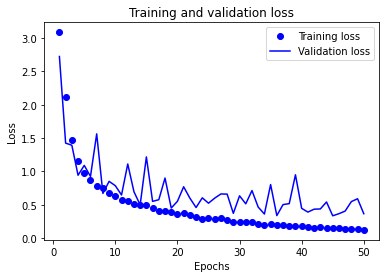

In [19]:
import matplotlib.pyplot as plt
history = model.history
loss = history .history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

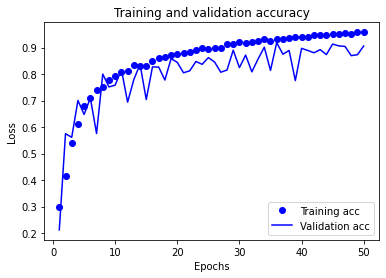

In [20]:
plt.clf()   # clear figure

acc = history .history['accuracy']
val_acc = history .history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Để predict trên tập test, ta cũng tạo một data generator với `class_mode` là `None`

In [ ]:
test_gen = test_datagen.flow_from_dataframe(dataframe=test_df, 
                                        directory="data/images", 
                                        x_col="image",
                                        class_mode=None,
                                        shuffle=False,
                                        batch_size=32,
                                        target_size=(224,224))

Lưu ý, thứ tự các lớp sẽ không tuân theo quy luật từ 0-10 mà sẽ theo thứ tự alphabet khi sử dụng ImageDataGenerator. Do đó ta cần ánh xạ các indices sau khi predict về lớp tương ứng của nó:

In [ ]:
pred = model.predict_generator(test_gen)

# pred là một ma trận xác suất của ảnh trên các lớp.
# Ta lấy lớp có xác suất cao nhất trên từng ảnh bằng hàm argmax
predicted_class_indices = np.argmax(pred, axis=1)

# Dictionary ánh xạ nhãn và index
labels = train_gen.class_indices

# Ánh xạ indices về nhãn đúng
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

# Baseline model 3: Transfer learning

In [12]:
# from effiecientnet improt EfficientNetB3
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input

In [13]:
import keras.backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [14]:
# Data Generator dùng cho training
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

# Data Generator dùng cho validation và testing
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

In [15]:
batch_size = 32

# ImageDataGenerator chỉ chấp nhận kiểu label là string, 
# ta chuyển cột label sang string
train_df["label"] = train_df["label"].map(lambda x: str(x))
# Chia dữ liệu thành train và validation
train_data, val_data = train_test_split(train_df, test_size=0.25)

# Tạo luồng dữ liệu cho quá trình train, các bạn có thể tìm hiểu các tham số ở Keras document
train_gen = train_datagen.flow_from_dataframe(dataframe=train_data, 
                                        directory="data/images", 
                                        x_col="image", 
                                        y_col="label",
                                        class_mode="categorical",
                                        target_size=(224,224), 
                                        batch_size=batch_size)

# Tạo luồng dữ liệu cho quá trình test
val_gen = test_datagen.flow_from_dataframe(dataframe=val_data, 
                                        directory="data/images", 
                                        x_col="image", 
                                        y_col="label",
                                        class_mode="categorical",
                                        shuffle=False,
                                        target_size=(224,224), 
                                        batch_size=batch_size)

Found 6175 validated image filenames belonging to 11 classes.
Found 2059 validated image filenames belonging to 11 classes.


In [35]:
# Số lượng training step mỗi epoch
steps_per_epoch = train_gen.n // batch_size
# Số lượng validation step
validation_steps = val_gen.n // batch_size

# Khởi tạo base model Resnet với pretrained weights từ ImageNet
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Tạo model hoàn chỉnh bằng cách thêm lớp classifier
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
predictions = tf.keras.layers.Dense(11, activation='softmax')(x)
model = tf.keras.Model(inputs = base_model.input, outputs = predictions)

# Freeze các lớp CNN ban đầu
base_model.trainable = False

# Tạo callback để lưu model có accuracy trên tập validation tốt nhất
mcp = tf.keras.callbacks.ModelCheckpoint("efficientnetb3.h5", monitor="val_f1",
                  save_best_only=True, mode='max', save_weights_only=True, verbose=1)
rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_f1', factor=0.1, mode='max', patience=5, min_lr=1e-8, verbose=1)

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss='categorical_crossentropy',
              metrics=[f1])

# model.load_weights("efficientnetb3.h5")

# Huấn luyện 10 epochs với learning rate lớn
model.fit(train_gen, 
                    steps_per_epoch=steps_per_epoch, 
                    epochs=10,
                    verbose=1, 
                    validation_data=val_gen,
                    validation_steps=validation_steps, 
                    callbacks=[mcp,rlr])

# Unfreeze toàn bộ mạng
base_model.trainable = True

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy',
              metrics=[f1])



# Huấn luyện 100 epochs với learning rate nhỏ
model.fit(train_gen, 
                    steps_per_epoch=steps_per_epoch, 
                    epochs=50,
                    verbose=1, 
                    validation_data=val_gen,
                    validation_steps=validation_steps, 
                    callbacks=[mcp])

Epoch 1/10
192/192 [==============================] - 105s 503ms/step - loss: 0.6081 - f1: 0.8087 - val_loss: 0.3072 - val_f1: 0.9039

Epoch 00001: val_f1 improved from -inf to 0.90387, saving model to efficientnetb3.h5
Epoch 2/10
192/192 [==============================] - 95s 492ms/step - loss: 0.4183 - f1: 0.8722 - val_loss: 0.3448 - val_f1: 0.8989

Epoch 00002: val_f1 did not improve from 0.90387
Epoch 3/10
192/192 [==============================] - 95s 492ms/step - loss: 0.3561 - f1: 0.8947 - val_loss: 0.2880 - val_f1: 0.9247

Epoch 00003: val_f1 improved from 0.90387 to 0.92471, saving model to efficientnetb3.h5
Epoch 4/10
192/192 [==============================] - 95s 493ms/step - loss: 0.3369 - f1: 0.9012 - val_loss: 0.2542 - val_f1: 0.9236

Epoch 00004: val_f1 did not improve from 0.92471
Epoch 5/10
192/192 [==============================] - 95s 493ms/step - loss: 0.2943 - f1: 0.9126 - val_loss: 0.2918 - val_f1: 0.9179

Epoch 00005: val_f1 did not improve from 0.92471
Epoch 6/1

In [ ]:
# Số lượng training step mỗi epoch
steps_per_epoch = train_gen.n // batch_size
# Số lượng validation step
validation_steps = val_gen.n // batch_size
# Khởi tạo base model Resnet với pretrained weights từ ImageNet
base_model = tf.keras.applications.ResNet50(input_shape=(224,224,3),
                                               include_top=False, 
                                               weights='imagenet')
    
# Tạo model hoàn chỉnh bằng cách thêm lớp classifier
model = tf.keras.Sequential([
      base_model,
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dense(11, activation='softmax')
    ])
    
    # Freeze các lớp CNN ban đầu
base_model.trainable = False
    
    # Tạo callback để lưu model có accuracy trên tập validation tốt nhất
mcp = tf.keras.callbacks.ModelCheckpoint("resnet50.h5", monitor="val_f1",
                      save_best_only=True, save_weights_only=True)
rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_f1', factor=0.1, mode='max', 
                                               patience=5, min_lr=1e-8, verbose=1)
    
    # Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss='categorical_crossentropy',
                  metrics=[f1])
    
    # Huấn luyện 10 epochs với learning rate lớn
model.fit(train_gen,steps_per_epoch=steps_per_epoch, 
                        epochs=10,
                        verbose=1, 
                        validation_data=val_gen,
                        validation_steps=validation_steps, 
                        callbacks=[mcp,rlr])
    
# Unfreeze toàn bộ mạng
base_model.trainable = True
    
# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy',
                  metrics=[f1])
    
# Huấn luyện 100 epochs với learning rate nhỏ
model.fit(train_gen,steps_per_epoch=steps_per_epoch, 
                        epochs=50,
                        verbose=1, 
                        validation_data=val_gen,
                        validation_steps=validation_steps, 
                        callbacks=[mcp])
    

94773248/94765736 [==============================] - 1s 0us/step
Epoch 1/10
192/192 [==============================] - 1948s 10s/step - loss: 1.3988 - f1: 0.7094 - val_loss: 0.8266 - val_f1: 0.8420
Epoch 2/10
192/192 [==============================] - 94s 492ms/step - loss: 0.9159 - f1: 0.8071 - val_loss: 0.9520 - val_f1: 0.8445
Epoch 3/10
192/192 [==============================] - 93s 482ms/step - loss: 0.7130 - f1: 0.8487 - val_loss: 0.9783 - val_f1: 0.8411
Epoch 4/10
192/192 [==============================] - 92s 481ms/step - loss: 0.6551 - f1: 0.8646 - val_loss: 0.8003 - val_f1: 0.8899
Epoch 5/10
192/192 [==============================] - 92s 479ms/step - loss: 0.7624 - f1: 0.8595 - val_loss: 0.9626 - val_f1: 0.8755
Epoch 6/10
192/192 [==============================] - 92s 479ms/step - loss: 0.6828 - f1: 0.8730 - val_loss: 1.0335 - val_f1: 0.8691
Epoch 7/10
192/192 [==============================] - 92s 479ms/step - loss: 0.5796 - f1: 0.8923 - val_loss: 1.0992 - val_f1: 0.8752
Epoc

In [1]:
from tensorflow.python.client import device_lib
print('Current Device: ', tf.test.gpu_device_name() + '\n')
device_lib.list_local_devices()

Current Device:  /device:GPU:0



[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1951670194529485588, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14509932544
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3114433218443238655
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

# Các phương pháp khác
Ngoài các baseline models được giới thiệu ở trên, có thể sử dụng thêm các phương pháp khác như:
- Sử dụng thư viện augmentation phức tạo hơn `imgaug`.
- Oversampling để làm tăng độ cân bằng của dữ liệu.
- Thêm weights vào hàm loss để làm tăng độ cân bằng giữa các nhãn.
- Sử dụng các kiến trúc CNN khác, hoặc kết hợp nhiều kiến trúc lại với nhau.
- Sử dụng ten-crop validation khi testing.
- Sử dụng các phương pháp cross-validation để chia dữ liệu khi huấn luyện.